# Function Approximation with a Multilayer Perceptron

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* training of neural networks by hand
* approximation of a function using a multilayer perceptron consisting of 3 hidden units with ReLU activation function and a linear output unit
* generation of Video illustrating piecewise linear approximation of a function by ReLU

In [15]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
%matplotlib inline

In [9]:
function_select = 4

def myfun(x):
    functions = {
        1: np.power(x,2), # quadratic function
        2: np.sin(x), # sinus
        3: np.sign(x), # signum
        4: np.exp(x), # exponential function
        5: np.abs(x)
    }
    return functions.get(function_select)



In [10]:
# Generate training data.
N = 32

x_train = np.linspace(-2, 2, num=N)

# Generate the evaluation data. 
# (can exceed the range of the training data to evaluate the prediction capabilities)
x_eval = np.linspace(-4, 4, num=4*N)

Function definitions. Here we consider a hard-coded two-layer perception with one hidden layer, using the rectified linear unit (ReLU) as activation function, and a linear output layer. The output of the perceptron can hence be written as
\begin{equation*}
\hat{f}(x,\boldsymbol{\theta}) = \sum_{i=1}^m v_i\sigma(x+b_i)
\end{equation*}
where $\sigma(x) = \text{ReLU}(x) = \begin{cases}0 & \text{if }x < 0 \\x & \text{otherwise}\end{cases}$.

Instead of specifying all the parameters individually, we group them in a single vector $\boldsymbol{\theta}$ with
\begin{equation*}
\boldsymbol{\theta}=\begin{pmatrix}
v_1 &  b_1 & v_2 & b_2 & \cdots & v_m & b_m\end{pmatrix}
\end{equation*}

In [11]:
def sigma(x):
    return np.maximum(0,x)

# First order derivative of sigma (here tanh)
def sigma_prime(x):
    retval = np.zeros(x.shape)
    retval[x >= 0] = 1
    return retval

def MLP(x,theta):
    y = np.zeros(x.shape)
    for k in range(0,len(theta),2):
        y += theta[k]*sigma(x+theta[k+1])
    return y

The cost function is the mean-squared error, i.e.,
\begin{equation*}
J(\boldsymbol{\theta},\mathbb{X}^{[\text{train}]},\mathbb{Y}^{[\text{train}]}) = \frac{1}{N}\sum_{i=1}^N\left(\hat{f}(x_i^{[\text{train}]},\boldsymbol{\theta}) - y_i^{[\text{train}]}\right)^2
\end{equation*}
The gradient of the cost function can be computed by hand as
\begin{equation*}
\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta},\mathbb{X}^{[\text{train}]},\mathbb{Y}^{[\text{train}]}) = \frac{1}{N}\sum_{i=1}^N\left(\hat{f}(x_i^{[\text{train}]},\boldsymbol{\theta}) - y_i^{[\text{train}]}\right)\begin{pmatrix}
\sigma(x_i^{[\text{train}]}+\theta_2) \\
\theta_1\sigma^\prime(x_i^{[\text{train}]}+\theta_2) \\
\sigma(x_i^{[\text{train}]}+\theta_4) \\
\theta_3\sigma^\prime(x_i^{[\text{train}]}+\theta_4) \\
\vdots \\
\sigma(x_i^{[\text{train}]}+\theta_{2m}) \\
\theta_{2m-1}\sigma^\prime(x_i^{[\text{train}]}+\theta_{2m})\end{pmatrix}
\end{equation*}
where 
\begin{equation*}
\sigma^\prime(x) = \left\{\begin{array}{ll}
0 &  \text{if }x < 0 \\
1 & \textrm{otherwise}\end{array}\right.
\end{equation*}

In [12]:
def cost_function(x, y, theta):
    # cost function is mean-squared error bvetween the training set x and the y
    difference = np.array([MLP(e, theta) for e in x]) - y
    return np.dot(difference.T, difference)/len(x)

# gradient of the cost function
def cost_function_gradient(x, y, theta):    
    gradient = np.zeros(len(theta))
    for k in range(len(x)):        
        ig = np.zeros(len(theta))
        for j in range(0,len(theta),2):
            ig[j]   = sigma(x[k]+theta[j+1])            
            ig[j+1] = theta[j]*sigma_prime(x[k]+theta[j+1])

        gradient += 2*(MLP(x[k],theta) - y[k])*ig
    return gradient / len(x)

Here, we use the Adam optimizer algorithm [1] to find the best configuration of parameters $\boldsymbol{\theta}$. See also the notebook `MLP_introduction.ipynb` for a description of the Adam optimizer.

1] D. P. Kingma and J. L. Ba, "Adam: A Method for Stochastic Optimization," published at ICLR 2015, available at https://arxiv.org/pdf/1412.6980.pdf

In [18]:
def approx_1d_function_adam(x_train, theta_initial, epochs):
    y_train = myfun(x_train)

    theta = theta_initial
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.001
    epsilon = 1e-8

    m = np.zeros(theta.shape)
    t = 0
    v = np.zeros(theta.shape)
    for k in tqdm.tqdm(range(epochs)):
        t += 1
        g = cost_function_gradient(x_train, y_train, theta)
        m = beta1*m + (1-beta1)*g
        v = beta2*v + (1-beta2)*(g**2)
        mhat = m/(1-beta1**t)
        vhat = v/(1-beta2**t)
        theta = theta - alpha*mhat/(np.sqrt(vhat)+epsilon)        
    return theta

Carry out the optimization using 10000 iterations with Adam and specify the number of components $m$.

In [19]:
epochs = 10000
m = 10

theta_initial = np.random.randn(2*m)

theta_adam = approx_1d_function_adam(x_train, theta_initial, epochs)

# compute evaluation
predictions = MLP(x_eval, theta_adam)

  0%|          | 0/10000 [00:00<?, ?it/s]

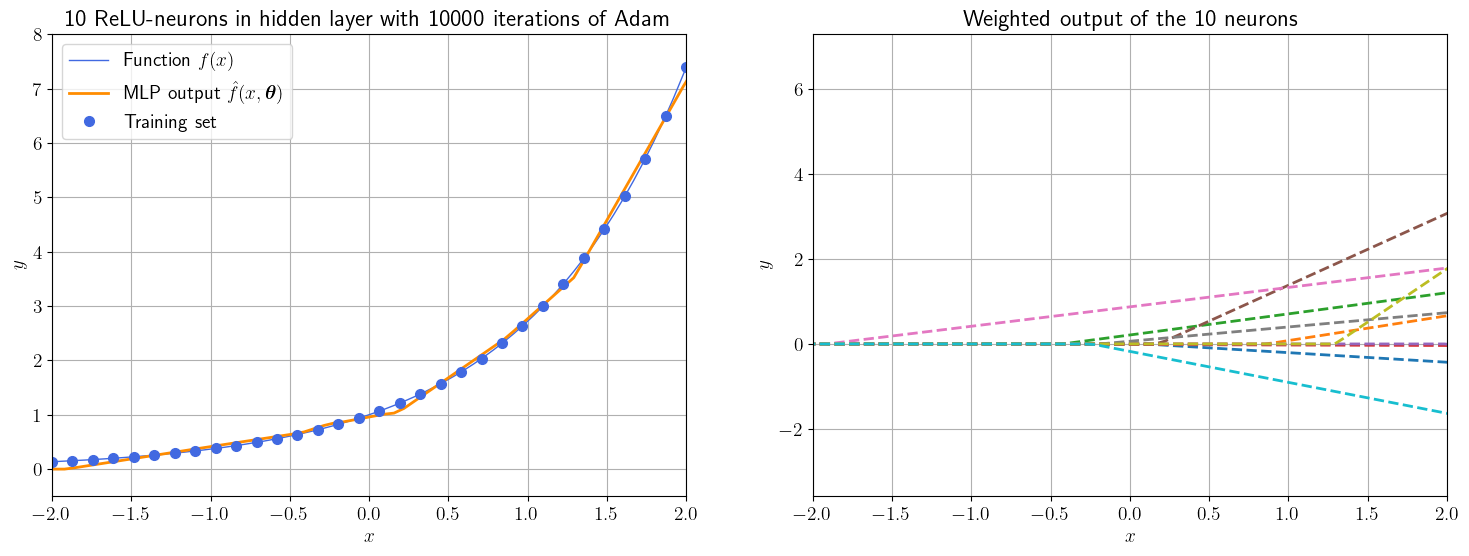

In [21]:
fig = plt.figure(1, figsize=(18,6))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{bm}')
ax = fig.add_subplot(1, 2, 1)
plt.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
plt.plot(x_eval, predictions, '-', label='output', color='darkorange', linewidth=2.0)
plt.plot(x_train, myfun(x_train), '.', color='royalblue',markersize=14)
plt.xlim((min(x_train),max(x_train)))
plt.ylim((-0.5,8))
plt.grid(which='both');
plt.rcParams.update({'font.size': 14})
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.title('%d ReLU-neurons in hidden layer with %d iterations of Adam' % (m,epochs))
plt.legend(['Function $f(x)$', r'MLP output $\hat{f}(x,\bm{\theta})$', 'Training set'])

ax = fig.add_subplot(1, 2, 2)
for k in range(0,len(theta_adam),2):
    plt.plot(x_eval, [theta_adam[k]*sigma(x + theta_adam[k+1]) for x in x_eval], '--', label='Relu %d' % (k//2), linewidth=2.0)
plt.grid(which='both');
plt.xlim((min(x_train),max(x_train)))
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.title('Weighted output of the %d neurons' % m)
#plt.savefig('MLP_ReLU_m%d_fun%d.pdf' % (m,function_select),bbox_inches='tight')
plt.show()    


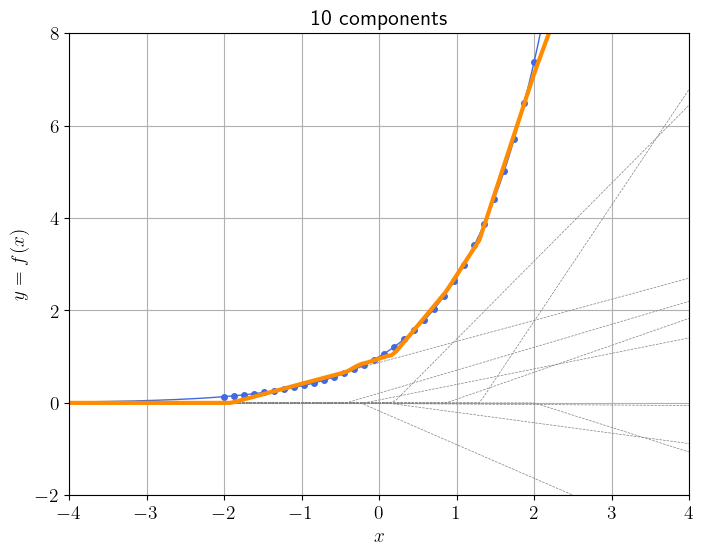

In [29]:
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.


fig, ax = plt.subplots(1, figsize=(8,6))

   
# Animation function.  This is called sequentially.
def animate(i):
    ax.clear()
    

    ax.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
    ax.plot(x_train, myfun(x_train), '.', color='royalblue',markersize=8)
    
    function_agg = np.zeros(len(x_eval))
    for k in range(0,i):    
        part_relu = np.array([theta_adam[2*k]*sigma(x + theta_adam[2*k+1]) for x in x_eval])
        ax.plot(x_eval, part_relu, '--', color='gray', linewidth=0.5)
        function_agg += part_relu
    
    ax.plot(x_eval, function_agg, '-', color='darkorange', linewidth=3.0)
    ax.grid(which='both')
    ax.set_title("%d components" % i, fontsize=16)
    ax.set_xlim((min(x_eval),max(x_eval)))
    ax.set_ylim((-2,8))
    ax.set_xlim((-4,4))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y=f(x)$')
    return fig,

# Call the animator.
anim = animation.FuncAnimation(fig, animate, frames=1+len(theta_adam)//2, interval=2000, blit=True, repeat=False)
# If you want to save the animation, use the following line.
#anim.save('basic_animation_test_fun%d.gif' % function_select, writer=PillowWriter(fps=.4))

HTML(anim.to_jshtml())